In [ ]:
# # Uncomment below for retraining from trained model and to save model
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# WanDB monitor model training
!pip install -qU wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.2 MB/s eta 0:00:00


## Imports

In [ ]:
# For WER metrics
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from jiwer import wer


In [ ]:
from IPython import display

## Getting Dataset

In [ ]:
# Download training data LJSpeech-1.1 dataset
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

--2024-04-21 17:48:41--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 24.199.73.137
Connecting to data.keithito.com (data.keithito.com)|24.199.73.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  17.0MB/s    in 2m 36s  

2024-04-21 17:51:17 (16.8 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [ ]:
# Unzip dataset
!tar -xvjf LJSpeech-1.1.tar.bz2 >/dev/null

In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"

data_path = "/content/LJSpeech-1.1/"#drive/MyDrive/MovieData"

wav_path = data_path + "wavs/"
metadata_path = data_path + "metadata.csv"

In [ ]:
print(wav_path,metadata_path)

/content/LJSpeech-1.1/wavs/ /content/LJSpeech-1.1/metadata.csv


In [ ]:
metadata = pd.read_csv(metadata_path, sep = "|", header = None, quoting=3)
metadata.columns = ["file", "transcription", "normalized_transcription"]
metadata = metadata[["file", "normalized_transcription"]]
metadata['normalized_transcription'] = metadata['normalized_transcription'].astype(str)
metadata = metadata.sample(frac=1).reset_index(drop=True)
#metadata = metadata[:54]
metadata.head()

,file,normalized_transcription
0,LJ022-0081,Funds allotted for each project should be actu...
1,LJ019-0203,But the condition of the great city jail was e...
2,LJ003-0096,"Quote, yet they had been long enough, he goes ..."
3,LJ005-0276,and for securing a proper system of prison dis...
4,LJ007-0029,The condition of the capitally-convicted priso...


In [ ]:
!file /content/LJSpeech-1.1/wavs/LJ12.wav

/content/LJSpeech-1.1/wavs/LJ12.wav: RIFF (little-endian) data, WAVE audio, Microsoft PCM, 16 bit, mono 22050 Hz


In [ ]:
split = int(len(metadata) * 0.9)
dfT = metadata[3:]
dfV = metadata[:3]
print(f"Training set: {len(dfT)}")
print(f"Validation set: {len(dfV)}")

Training set: 55
Validation set: 3


## Parameters

In [ ]:
# Parameters
epochs = 10
frame_length = 256
frame_step = 160
ftt_length = 256
lr = 1e-4
batch_size = 4

## Creating Vocabulary

In [ ]:
ch = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
stoi = keras.layers.StringLookup(vocabulary=ch, oov_token="")
itos = keras.layers.StringLookup(vocabulary=stoi.get_vocabulary() , oov_token="", invert=True)

print("Vocabulary:", stoi.get_vocabulary())
print("Vocabulary size:", len(stoi.get_vocabulary()))

Vocabulary: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']
Vocabulary size: 31


In [ ]:
def encodeSimpleSample(wavFile, label):
    wav = tf.io.read_file(wav_path + wavFile + ".wav")

    wav, _ = tf.audio.decode_wav(wav)
    wav = tf.squeeze(wav, axis=-1)
    audio = tf.cast(wav, tf.float32)
    spectogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step)

    spectogram = tf.abs(spectogram)
    spectogram = tf.math.pow(spectogram, 0.5)

    means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
    spectogram = (spectogram - means) / stddevs + 1e-9

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = stoi(label)
    return spectogram, label


## Preparing Dataset

In [ ]:
metadata['normalized_transcription'] = metadata['normalized_transcription'].astype(str).str.lower()

In [ ]:
print(metadata["normalized_transcription"].dtype)
print(metadata["file"].dtype)
print(metadata["normalized_transcription"].head())

object
object
0    funds allotted for each project should be actu...
1    but the condition of the great city jail was e...
2    quote, yet they had been long enough, he goes ...
3    and for securing a proper system of prison dis...
4    the condition of the capitally-convicted priso...
Name: normalized_transcription, dtype: object


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((list(dfT["file"]),list(dfT["normalized_transcription"])))
train_dataset = train_dataset.map(encodeSimpleSample, num_parallel_calls=tf.data.AUTOTUNE,).padded_batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((list(dfV["file"]),list(dfV["normalized_transcription"])))
val_dataset = val_dataset.map(encodeSimpleSample, num_parallel_calls=tf.data.AUTOTUNE,).padded_batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Building Model

In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
@keras.saving.register_keras_serializable(name="CTC_loss")
def CTC_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
run = wandb.init(project='Speech2text_part1',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": lr,
                     "epochs": epochs,
                     "batch_size": batch_size,
                     "loss_function": "CTC Loss",
                     "architecture": "CNN + GRU",
                     "dataset": "LJSpeech-1.1"
                 })
config = wandb.config  # We'll use this to configure our experiment

wandb: Currently logged in as: kmayush27399. Use `wandb login --relogin` to force relogin


In [ ]:
def build_model(input_dim, output_dim, rnn_layers = 5, rnn_units = 128):
    input = layers.Input((None, input_dim), name = "input")
    x = layers.Reshape((-1, input_dim,1), name = "expand_dim")(input)
    x = layers.Conv2D(filters = 32, kernel_size = (11, 41), strides = [2, 2], padding = "same", use_bias = False,name = "conv1")(x)
    x = layers.BatchNormalization(name = "bn1")(x)
    x = layers.Conv2D(filters = 32, kernel_size = [11, 21], strides = [1, 2], padding = "same", use_bias = False, name = "conv2")(x)
    x = layers.BatchNormalization(name = "bn2")(x)
    x = layers.ReLU(name = "relu1")(x)
    x = layers.Reshape((-1, x.shape[-2]* x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units = rnn_units, activation = "tanh", recurrent_activation = "sigmoid", use_bias = True, return_sequences = True, reset_after = True, name = f"gru{i}")
        x = layers.Bidirectional(recurrent, name = f"bidirectional{i}", merge_mode = 'concat')(x)
        if i < rnn_layers:
            x = layers.Dropout(rate = 0.5)(x)

    x = layers.Dense(units = rnn_units*2, name = "dense1")(x)
    x = layers.ReLU(name = "relu2")(x)
    x = layers.Dropout(rate = 0.5)(x)
    output = layers.Dense(output_dim+1, activation = "softmax", name = "output")(x)
    model = keras.Model(inputs = input, outputs = output, name = "speech2text")
    opt = keras.optimizers.Adam(learning_rate = config.learning_rate)
    model.compile(optimizer = opt, loss = CTC_loss)
    return model


In [ ]:
model = build_model(input_dim = ftt_length // 2 + 1, output_dim = stoi.vocabulary_size(), rnn_units=512)
model.summary()

Model: "speech2text"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 129, 1)      0         
                                                                 
 conv1 (Conv2D)              (None, None, 65, 32)      14432     
                                                                 
 bn1 (BatchNormalization)    (None, None, 65, 32)      128       
                                                                 
 conv2 (Conv2D)              (None, None, 33, 32)      236544    
                                                                 
 bn2 (BatchNormalization)    (None, None, 33, 32)      128       
                                                                 
 relu1 (ReLU)                (None, None, 33, 32)      

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length = input_len, greedy = True)[0][0]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(itos(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
class CallBackEval(keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch:int, logs = None):
        prediction = []
        target = []
        for batch in self.dataset:
            x, y = batch
            batch_pred = model.predict(x)
            batch_pred = decode_batch_predictions(batch_pred)
            prediction.extend(batch_pred)
            for label in y:
                label = (tf.strings.reduce_join(itos(label)).numpy().decode("utf-8"))
                target.append(label)
        wer_score = wer(target, prediction)
        #wandb.log({'WER Score' : wer_score})
        print(f"WER: {wer_score:.4f}")
        for i in np.random.randint(0, len(prediction), 2):
            print(f"Prediction: {prediction[i]}")
            print(f"Target: {target[i]}")
            print()

In [ ]:
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="STT_model_{epoch:02d}"),
]

NameError: name 'WandbMetricsLogger' is not defined

## Training Model

In [ ]:
validation_callback = CallBackEval(val_dataset)
history = model.fit(train_dataset, epochs = epochs, validation_data = val_dataset, callbacks = [validation_callback])

## Inference

In [ ]:
# Inference
predictions = []
targets = []
for batch in val_dataset:
  X, y = batch
  batch_pred = model.predict(X)
  batch_pred = decode_batch_predictions(batch_pred)
  predictions.extend(batch_pred)

  for label in y:
      label = (tf.strings.reduce_join(itos(label)).numpy().decode("utf-8"))
      targets.append(label)
wer_score = wer(targets, predictions)


print(f"WER: {wer_score:.4f}")
for i in np.random.randint(0, len(predictions), 2):
    print(f"Prediction: {predictions[i]}")
    print(f"Target: {targets[i]}")
    print()

1/1 [==============================] - 1s 544ms/step
WER: 0.0926
Prediction: not only ready cooked but ready digested and the alimentary canell become superfluus as disappeared and again
Target: not only ready cooked but ready digested and the alimentary canal become superfluous has disappeared and again

Prediction: this bariety was often extended to albranches of prison aconnomy
Target: this variety was often extended to all branches of prison economy



In [ ]:
run.finish()

WER Score,▆▇▁█
epoch/epoch,▁▁▅█
epoch/learning_rate,▁▁▁▁
epoch/loss,█▅▃▁
epoch/val_loss,▃▁▅█
WER Score,0.09553
epoch/epoch,2
epoch/learning_rate,0.0001
epoch/loss,21.20452
epoch/val_loss,21.19286


In [ ]:
model.save("/content/drive/MyDrive/speech2text_apr20_4.keras")

In [ ]:
wandb.save("Speech2text.keras")

[]

## Reload Model

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/speech2text4.keras")

In [ ]:
def speechToText(audio_file_with_path):
    wav = tf.io.read_file(audio_file_with_path)
    wav, _ = tf.audio.decode_wav(wav)
    wav = tf.squeeze(wav, axis=-1)
    audio = tf.cast(wav, tf.float32)
    spectogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step)

    spectogram = tf.abs(spectogram)
    spectogram = tf.math.pow(spectogram, 0.5)

    means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
    spectogram = (spectogram - means) / stddevs + 1e-9

    # label = tf.strings.lower(label)
    # label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # label = stoi(label)
    #file = tf.io.read_file(audio_file)
    # wav, _ = tf.audio.decode_wav(file)
    batch_pred = model.predict(wav)
    return decode_batch_predictions(batch_pred)


## Testing

In [ ]:
# Testing Reconstructed Model
#fig  = plt.figure(figsize=(10, 10))
for batch in train_dataset.take(1):
    #print(batch[0])
    spectogram = batch[0][0].numpy()
    #print(batch[0].shape)
    label = batch[1][0]
    X = batch[0].numpy()
    label = tf.strings.reduce_join(itos(label)).numpy().decode("utf-8")
    #ax = plt.subplot(2, 1, 1)
    #ax.imshow(spectogram, vmax = 1)
    #ax.set_title(label)

    #ax.axis("off")

    file = tf.io.read_file(wav_path + list(dfT["file"])[0] + ".wav")
    wav, _ = tf.audio.decode_wav(file)
    print(batch[1][1][0])
    #batch_pred = model.predict(X)
    print("Label : ",label)
    print("Prediction : ",decode_batch_predictions(batch_pred)[0])
    print()

tf.Tensor(2, shape=(), dtype=int64)
Label :  the lifting had been so complete in this case that there was no trace of the print on the rifle itself when it was examined by latona
Prediction :  the lifting had been so complete in this case that there was no trace of the print on the rifle itself when it was examined by latona



In [ ]:
wav = tf.io.read_file('/content/LJ001-0001.wav')
wav, _ = tf.audio.decode_wav(wav)
wav = tf.squeeze(wav, axis=-1)
audio = tf.cast(wav, tf.float32)
spectogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step)

spectogram = tf.abs(spectogram)
spectogram = tf.math.pow(spectogram, 0.5)

means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
spectogram = (spectogram - means) / stddevs + 1e-9

In [ ]:
spectogram = spectogram.numpy()
#spectogram = np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])

In [ ]:
spectogram = tf.expand_dims(spectogram, 0)

In [ ]:
spectogram.shape

TensorShape([1, 1329, 129])

In [ ]:
Y = model(spectogram)

In [ ]:
decode_batch_predictions(Y)[0]

"printing in the only sense with which we are at present concerned differs from most if not from all the arts and craft's represented in the exibitn"

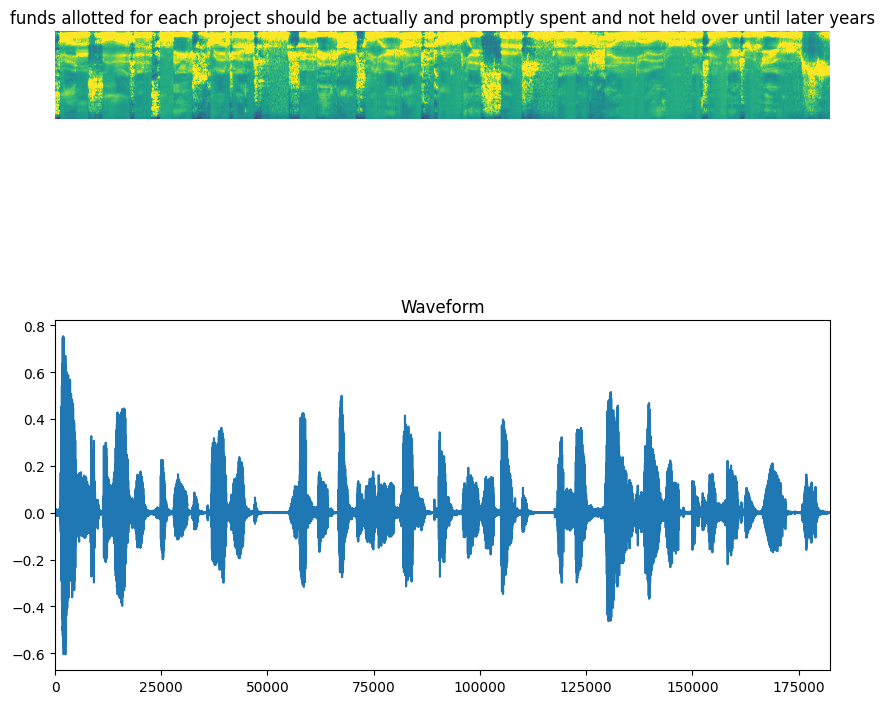

In [ ]:
fig  = plt.figure(figsize=(10, 10))
for batch in train_dataset.take(1):
    spectogram = batch[0][0].numpy()
    spectogram = np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
    label = batch[1][0]

    label = tf.strings.reduce_join(itos(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectogram, vmax = 1)
    ax.set_title(label)
    ax.axis("off")

    file = tf.io.read_file(wav_path + list(dfT["file"])[0] + ".wav")
    wav, _ = tf.audio.decode_wav(file)
    wav = wav.numpy()
    ax = plt.subplot(2, 1, 2)
    ax.plot(wav)
    ax.set_title("Waveform")
    ax.set_xlim(0, len(wav))

plt.show()

(-0.5, 1328.5, 128.5, -0.5)

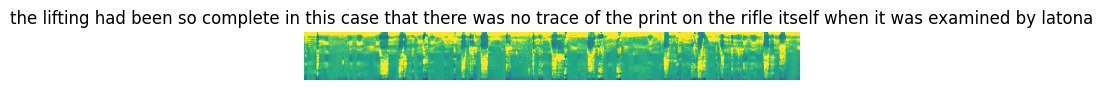

In [ ]:
ax = plt.subplot(2, 1, 1)
ax.imshow(spectogram, vmax = 1)
ax.set_title(label)
ax.axis("off")

In [ ]:
wav,_ = tf.audio.decode_wav(wav)

In [ ]:
type(wav)

tensorflow.python.framework.ops.EagerTensor